In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
import cv2

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train_no_resize = [0]*len(train_ids)
Y_train_no_resize = [0]*len(train_ids)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    X_train_no_resize[n] = img
    mask_bool = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        if mask_bool == 0:
            mask = np.zeros((mask_.shape[0], mask_.shape[1], 1), dtype=np.bool)
            mask_bool = 1
        mask = np.maximum(mask, mask_)
    Y_train_no_resize[n] = mask

Getting train images and masks ... 


100%|██████████| 670/670 [01:23<00:00,  8.06it/s]


670
Counter({(256, 256, 3): 334, (256, 320, 3): 112, (520, 696, 3): 92, (360, 360, 3): 91, (1024, 1024, 3): 16, (512, 640, 3): 13, (603, 1272, 3): 6, (260, 347, 3): 5, (1040, 1388, 3): 1})


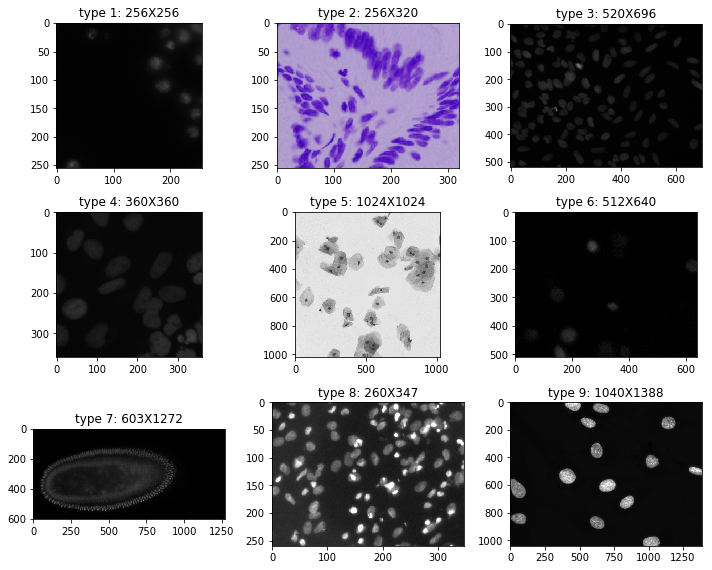

In [6]:
import collections

print len(X_train_no_resize)
shape_counter = collections.Counter([i.shape for i in X_train_no_resize])
print shape_counter
type_1 = [i for i in X_train_no_resize if i.shape == (256,256,3)]
type_2 = [i for i in X_train_no_resize if i.shape == (256,320,3)]
type_3 = [i for i in X_train_no_resize if i.shape == (520,696,3)]
type_4 = [i for i in X_train_no_resize if i.shape == (360,360,3)]
type_5 = [i for i in X_train_no_resize if i.shape == (1024,1024,3)]
type_6 = [i for i in X_train_no_resize if i.shape == (512,640,3)]
type_7 = [i for i in X_train_no_resize if i.shape == (603, 1272,3)]
type_8 = [i for i in X_train_no_resize if i.shape == (260,347,3)]
type_9 = [i for i in X_train_no_resize if i.shape == (1040,1388,3)]

fig1 = plt.figure() # create a figure with the default size 

im1 = type_1[0]
ax1 = fig1.add_subplot(3,3,1) 
ax1.imshow(im1, interpolation='none')
ax1.set_title('type 1: 256X256')

im2 = type_2[0]
ax2 = fig1.add_subplot(3,3,2) 
ax2.imshow(im2, interpolation='none')
ax2.set_title('type 2: 256X320')

im3 = type_3[0]
ax3 = fig1.add_subplot(3,3,3) 
ax3.imshow(im3, interpolation='none')
ax3.set_title('type 3: 520X696')

im4 = type_4[0]
ax4 = fig1.add_subplot(3,3,4) 
ax4.imshow(im4, interpolation='none')
ax4.set_title('type 4: 360X360')

im5 = type_5[0]
ax5 = fig1.add_subplot(3,3,5) 
ax5.imshow(im5, interpolation='none')
ax5.set_title('type 5: 1024X1024')

im6 = type_6[0]
ax6 = fig1.add_subplot(3,3,6) 
ax6.imshow(im6, interpolation='none')
ax6.set_title('type 6: 512X640')

im7 = type_7[0]
ax7 = fig1.add_subplot(3,3,7) 
ax7.imshow(im7, interpolation='none')
ax7.set_title('type 7: 603X1272')

im8 = type_8[0]
ax8 = fig1.add_subplot(3,3,8) 
ax8.imshow(im8, interpolation='none')
ax8.set_title('type 8: 260X347')

im9 = type_9[0]
ax9 = fig1.add_subplot(3,3,9) 
ax9.imshow(im9, interpolation='none')
ax9.set_title('type 9: 1040X1388')

plt.tight_layout()
plt.savefig('example.png')

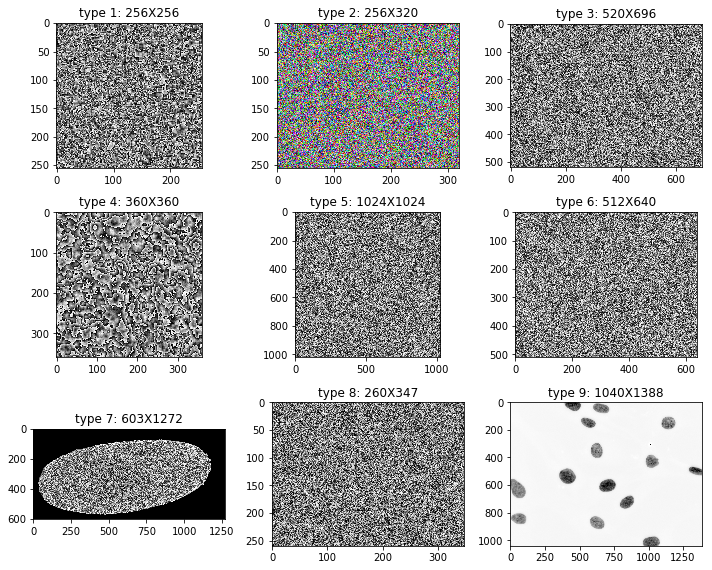

In [7]:
def average_images(type_image, type_avg):
    for i in type_image:
        type_avg += i
    return type_avg/float(len(type_image))

fig2 = plt.figure() # create a figure with the default size 

type_1_avg = np.zeros((256,256,3))
type_1_avg = average_images(type_1, type_1_avg)
ax1 = fig2.add_subplot(3,3,1) 
ax1.imshow(type_1_avg, interpolation='none')
ax1.set_title('type 1: 256X256')

type_2_avg = np.zeros((256,320,3))
type_2_avg = average_images(type_2, type_2_avg)
ax2 = fig2.add_subplot(3,3,2) 
ax2.imshow(type_2_avg, interpolation='none')
ax2.set_title('type 2: 256X320')

type_3_avg = np.zeros((520,696,3))
type_3_avg = average_images(type_3, type_3_avg)
ax3 = fig2.add_subplot(3,3,3) 
ax3.imshow(type_3_avg, interpolation='none')
ax3.set_title('type 3: 520X696')

type_4_avg = np.zeros((360,360,3))
type_4_avg = average_images(type_4, type_4_avg)
ax4 = fig2.add_subplot(3,3,4) 
ax4.imshow(type_4_avg, interpolation='none')
ax4.set_title('type 4: 360X360')

type_5_avg = np.zeros((1024,1024,3))
type_5_avg = average_images(type_5, type_5_avg)
ax5 = fig2.add_subplot(3,3,5) 
ax5.imshow(type_5_avg, interpolation='none')
ax5.set_title('type 5: 1024X1024')

type_6_avg = np.zeros((512,640,3))
type_6_avg = average_images(type_6, type_6_avg)
ax6 = fig2.add_subplot(3,3,6) 
ax6.imshow(type_6_avg, interpolation='none')
ax6.set_title('type 6: 512X640')

type_7_avg = np.zeros((603,1272,3))
type_7_avg = average_images(type_7, type_7_avg)
ax7 = fig2.add_subplot(3,3,7) 
ax7.imshow(type_7_avg, interpolation='none')
ax7.set_title('type 7: 603X1272')

type_8_avg = np.zeros((260,347,3))
type_8_avg = average_images(type_8, type_8_avg)
ax8 = fig2.add_subplot(3,3,8) 
ax8.imshow(type_8_avg, interpolation='none')
ax8.set_title('type 8: 260X347')

type_9_avg = np.zeros((1040,1388,3))
type_9_avg = average_images(type_9, type_9_avg)
ax9 = fig2.add_subplot(3,3,9) 
ax9.imshow(type_9_avg, interpolation='none')
ax9.set_title('type 9: 1040X1388')

plt.tight_layout()
plt.savefig('average.png')

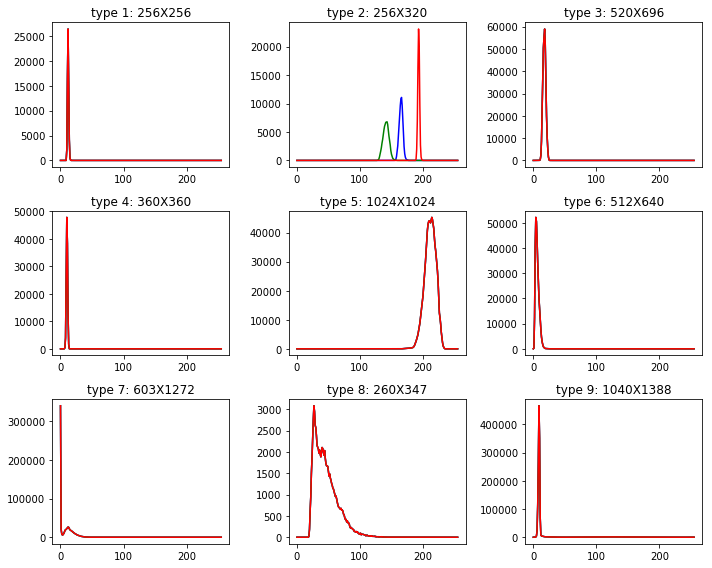

In [8]:
def create_3_color_histogram(img,ax):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img.astype(np.uint8)],[i],None,[256],[0,256])
        ax.plot(histr,color = col)
#         ax.xlim([0,256])

fig2 = plt.figure() # create a figure with the default size 

ax1 = fig2.add_subplot(3,3,1)
create_3_color_histogram(type_1_avg,ax1) 
ax1.set_title('type 1: 256X256')

ax2 = fig2.add_subplot(3,3,2)
create_3_color_histogram(type_2_avg,ax2) 
ax2.set_title('type 2: 256X320')

ax3 = fig2.add_subplot(3,3,3)
create_3_color_histogram(type_3_avg,ax3) 
ax3.set_title('type 3: 520X696')

ax4 = fig2.add_subplot(3,3,4)
create_3_color_histogram(type_4_avg,ax4) 
ax4.set_title('type 4: 360X360')

ax5 = fig2.add_subplot(3,3,5)
create_3_color_histogram(type_5_avg,ax5) 
ax5.set_title('type 5: 1024X1024')

ax6 = fig2.add_subplot(3,3,6)
create_3_color_histogram(type_6_avg,ax6) 
ax6.set_title('type 6: 512X640')

ax7 = fig2.add_subplot(3,3,7)
create_3_color_histogram(type_7_avg,ax7) 
ax7.set_title('type 7: 603X1272')

ax8 = fig2.add_subplot(3,3,8)
create_3_color_histogram(type_8_avg,ax8) 
ax8.set_title('type 8: 260X347')

ax9 = fig2.add_subplot(3,3,9)
create_3_color_histogram(type_9_avg,ax9) 
ax9.set_title('type 9: 1040X1388')

plt.tight_layout()
plt.savefig('average.png')

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

#Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:53<00:00,  5.90it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 64.72it/s]

Done!


In [50]:
image_dict = {}
actual_image_dict = {}
size_dict = collections.defaultdict(int)
average_inten = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    image_dict[id_] = img.shape
    actual_image_dict[id_] = img
    average_inten.append(np.mean(img))
    size_dict[img.shape] += 1
    

100%|██████████| 670/670 [00:06<00:00, 101.73it/s]


('Images: ', 670)
('Nuclei', 29461)
('Number of sizes: ', 9)
defaultdict(<type 'int'>, {(256, 320, 3): 112, (603, 1272, 3): 6, (1024, 1024, 3): 16, (360, 360, 3): 91, (256, 256, 3): 334, (1040, 1388, 3): 1, (520, 696, 3): 92, (260, 347, 3): 5, (512, 640, 3): 13})
((256, 320, 3), 410.38402392140114)
((603, 1272, 3), 157.07116920842412)
((512, 640, 3), 1194.705596107056)
((360, 360, 3), 1521.5627928772258)
((256, 256, 3), 176.39368840427764)
((1040, 1388, 3), 7244.071428571428)
((520, 696, 3), 613.5043969849246)
((260, 347, 3), 162.5808823529412)
((1024, 1024, 3), 233.217843866171)


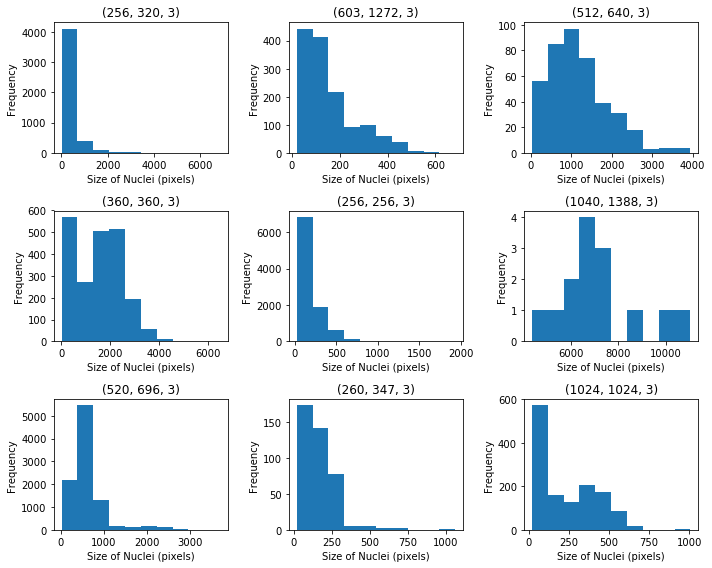

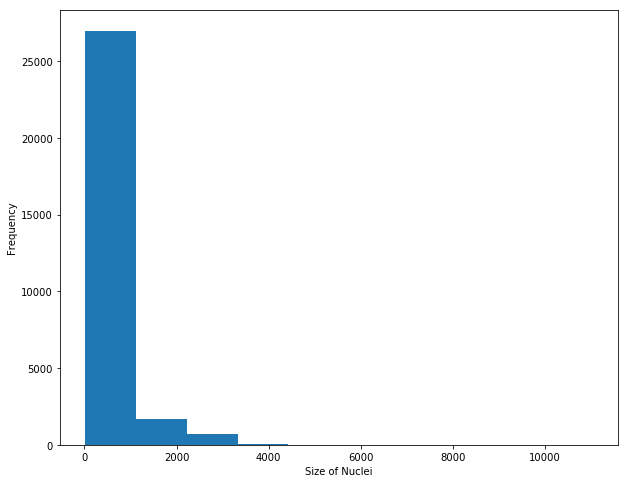

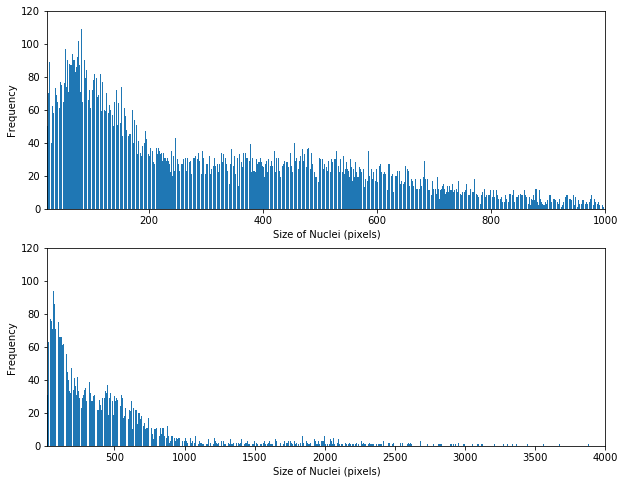

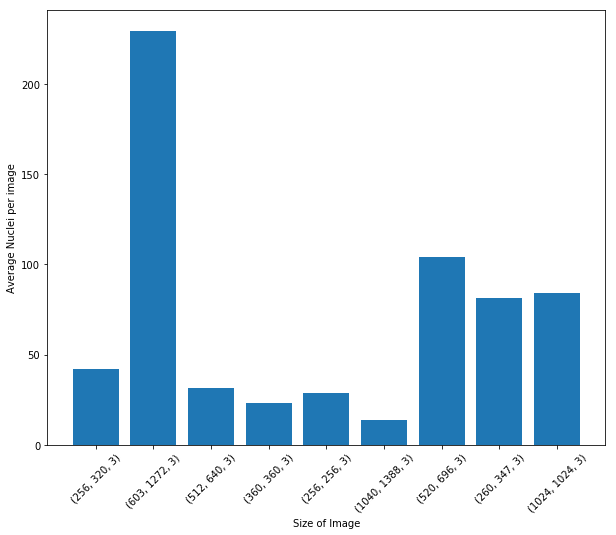

In [41]:
import matplotlib.pyplot as plt

label_counter = collections.defaultdict(int)
shape_counter = collections.defaultdict(int)
mask_sizes = collections.defaultdict(list)
mask_sizes_by_image_size = collections.defaultdict(list)
mask_pixel_intense = collections.defaultdict(int)
total_mask_size = []

with open('data/stage1_train_labels.csv','r') as f:
    f.readline()
    for line in f:
        image_id, mask = line.split(',')
        label_counter[image_id] += 1
        shape_counter[image_dict[image_id]] += 1.0 / size_dict[image_dict[image_id]]
        #x, y, z = image_dict[image_id]
        #shape_counter[image_dict[image_id]] += 1.0 / (x*y*size_dict[image_dict[image_id]])
        
        flat_image = actual_image_dict[image_id].flatten()
        
        mask = mask.split(' ')
        mask_pix = 0
        for i in range(0, len(mask), 2):
            mask_pix += int(mask[i+1])
            for j in range(int(mask[i+1])):
                mask_pixel_intense[flat_image[int(mask[i]) + j]] += 1
        mask_sizes[image_dict[image_id]].append(mask_pix)
        mask_sizes_by_image_size[image_dict[image_id]].append(mask_pix)
        total_mask_size.append(mask_pix)
            
    
print('Images: ', len(label_counter.keys()))
print('Nuclei', sum([label_counter[key] for key in label_counter.keys()]))

print('Number of sizes: ', len(shape_counter.keys()))

mask_size_counter = collections.Counter(total_mask_size)
print(size_dict)

plt.figure()
i = 1
for size in mask_sizes_by_image_size.keys():
    print(size,sum(mask_sizes_by_image_size[size])/float(len(mask_sizes_by_image_size[size])))
    plt.subplot(3,3,i)
    plt.hist(mask_sizes_by_image_size[size])
    plt.xlabel('Size of Nuclei (pixels)')
    plt.ylabel('Frequency')
    plt.title(size)
    i += 1
plt.tight_layout()
plt.savefig('hist_by_size.png')


plt.figure()
plt.hist(total_mask_size)
plt.xlabel('Size of Nuclei')
plt.ylabel('Frequency')

plt.figure()
plt.subplot(2,1,1)
plt.bar(dict(mask_size_counter).keys(), mask_size_counter.values())
plt.xlabel('Size of Nuclei (pixels)')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_xlim([22,1000])
axes.set_ylim([0,120])
plt.subplot(2,1,2)
plt.bar(dict(mask_size_counter).keys(), mask_size_counter.values())
plt.xlabel('Size of Nuclei (pixels)')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_xlim([22,4000])
axes.set_ylim([0,120])
plt.savefig('hist.png')

plt.figure()
plt.bar(range(len(shape_counter)), list(shape_counter.values()), align='center')
plt.xticks(range(len(shape_counter)), list(shape_counter.keys()), rotation=45)
plt.xlabel('Size of Image')
plt.ylabel('Average Nuclei per image')
plt.savefig('bar.png')
plt.show()

In [27]:
intense = collections.defaultdict(int)
for img in X_train_no_resize:
    for pixel in img.flatten():
        intense[pixel] += 1

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
h

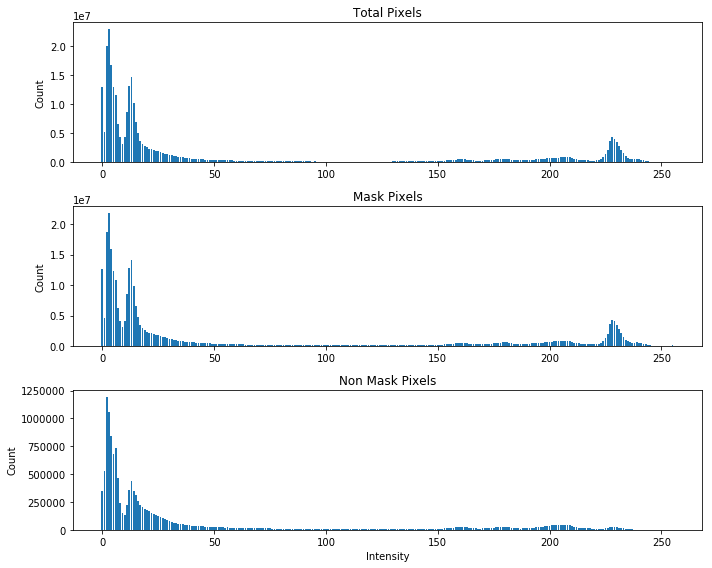

In [49]:
plt.figure
plt.subplot(3,1,1)
plt.bar(intense.keys(), list(intense.values()), align='center')
plt.ylabel("Count")
plt.title("Total Pixels")

plt.subplot(3,1,3)
plt.bar(mask_pixel_intense.keys(), list(mask_pixel_intense.values()), align='center')

non_mask_pixel_intense = {}
for i in intense.keys():
    non_mask_pixel_intense[i] = intense[i] - mask_pixel_intense[i]
plt.ylabel("Count")
plt.title("Non Mask Pixels")
plt.xlabel("Intensity")

plt.subplot(3,1,2)
plt.bar(non_mask_pixel_intense.keys(), list(non_mask_pixel_intense.values()), align='center')

plt.ylabel("Count")
plt.title("Mask Pixels")
plt.tight_layout()


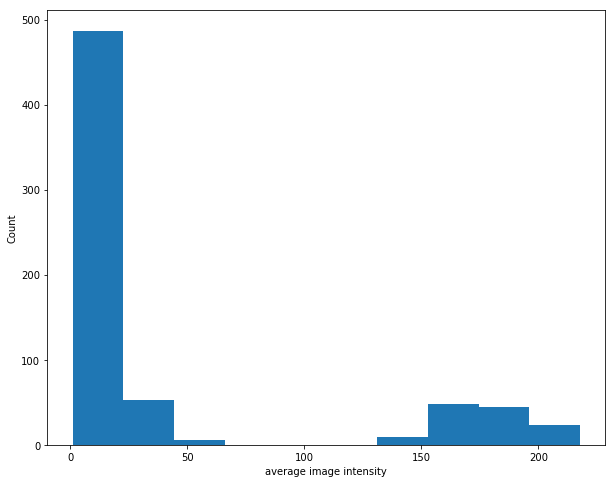

In [54]:
plt.hist(average_inten)
plt.xlabel("average image intensity")
plt.ylabel("Count")